
# Jesus Eduardo Uicab Briceño
## Group Whatsapp " PUBG TEAM"

Import libraries

In [11]:
from PIL import Image, ImageDraw, ImageFont
import calmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

define function to read and clean whatsapp chat file

In [12]:
def read_whatsapp(path):
    raw = open(path, encoding='utf-8')
    chats = raw.readlines()
    messages = []
    name = []
    time = []

    for line in chats:
        if len(line.split(' - '))!=1:
            if len(line.split(' - ')[1].split(': '))==2:
                name.append(line.split(' - ')[1].split(':')[0])
                messages.append(line.split(' - ')[1].split(':')[1].rstrip('\n'))
                time.append(line.split(' - ')[0])
        else:
            messages[-1] = messages[-1] + " " + line

    df = pd.DataFrame({"message":messages, "name":name, 'time':time})
    df["time"] = pd.to_datetime(df["time"])


    return df

In [13]:
def read_line(path):
    raw = open(path, encoding='utf-8')
    chats = raw.readlines()
    messages = []
    name = []
    time = []
    
    for i, line in enumerate(chats):
        if line.split('\t')[0]=="\n":
            date = chats[i+1].rsplit("(", 2)[0]
        elif len(line.split('\t'))==3:
            name.append(line.split('\t')[1])
            messages.append(line.split('\t')[2].rstrip())
            time.append(datetime.strptime(date + " " + line.split('\t')[0], '%Y/%m/%d %H:%M'))
    
    df = pd.DataFrame({"message":messages, "name":name, 'time':time})
    
    return df

In [15]:
chat = read_whatsapp("WhatsApp Chat with Team PUBG.txt")

### fecha de creacion del Grupo

In [76]:
def timeline(df):
    days = (df.time.iloc[-1] - df.time.iloc[0]).days
    first_day = datetime.strftime(df.time.iloc[0], format="%A, %d %b %Y")
    last_day = datetime.strftime(df.time.iloc[-1], format="%A, %d %b %Y")

    day_img = Image.open("img/day.png")
    img = ImageDraw.Draw(day_img)
    font = ImageFont.truetype(font="corbel.ttf", size=40)
    font_day = ImageFont.truetype(font="corbel.ttf", size=24)
    font_date = ImageFont.truetype(font="corbel.ttf", size=27)
    img.text((290,130), str(days), font=font, fill=(0, 0, 0))
    img.text((360,140), "days", font=font_day, fill=(0, 0, 0))
    img.text((120,50), first_day, font=font_date, fill=(0, 0, 0))
    img.text((120,220), last_day, font=font_date, fill=(0, 0, 0))
    return day_img

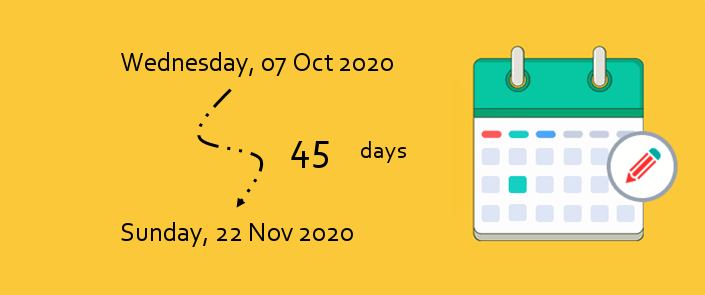

In [17]:
timeline(chat)

### Mensajes totales del grupo

In [20]:
def messages_summary(df):
    total_message = len(df.index)
    average_message_day = df.set_index(df.time).message.resample("D").count().mean()
    average_message_week = df.set_index(df.time).message.resample("W").count().mean()
    average_message_month = df.set_index(df.time).message.resample("M").count().mean()
    users = {user: df[df.name == user] for user in df.name.unique()}

    chat_img = Image.open("img/chat_1.png")
    img = ImageDraw.Draw(chat_img)
    font = ImageFont.truetype(font="arial.ttf", size=20)
    font_2 = ImageFont.truetype(font="arial.ttf", size=13)
    img.text((100,100), str(total_message), font=font, fill=(0,128,128))
    img.text((78,120), "Messages", font=font, fill=(0,128,128))
    img.text((240,70), ("Daily Average messages {:0.0f}".format(average_message_day)), font=font_2, fill=(0,128,128))
    img.text((240,90), ("Weekly Average messages {:0.0f}".format(average_message_week)), font=font_2, fill=(0,128,128))
    img.text((240,110), ("Monthly Average messages {:0.0f}".format(average_message_month)), font=font_2, fill=(0,128,128))
    for i, user in enumerate(users):
        img.text((240,120+(i+1)*20), ("Number of messages " + user + " sent {:0.0f}".format(len(users[user].index))), font=font_2, fill=(0,128,128))
    
    return chat_img

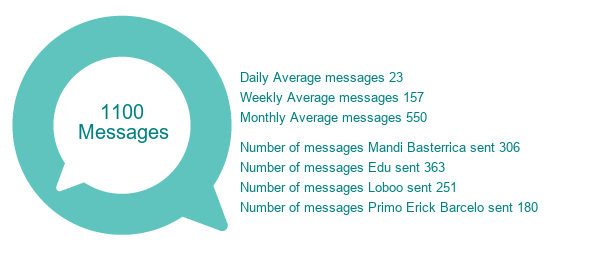

In [21]:
messages_summary(chat)

### ¿Quién recibe una respuesta rápida?

In [70]:
def chat_reply(df):
    dff = df.copy()
    dff["response_time"] = dff.time.diff()

    dff["response_time_s"] = dff.response_time - timedelta(hours=12)
    dff["response_time_s"] = dff.response_time_s.apply(lambda x: x.total_seconds())
    response_time_obj = dff[dff["response_time_s"] < 0]
    response_time_obj["response_time_s"] = response_time_obj.response_time.values.astype("int64")

    bales_chat = response_time_obj.groupby("name").mean()
    bales_chat["response_time_s"] = pd.to_timedelta(bales_chat["response_time_s"])

    a=bales_chat.response_time_s.apply(lambda x: x.total_seconds())
    minutes=a//60
    seconds=a-(minutes*60)

    value=bales_chat.response_time_s.values.astype("float64")/60/1000000000
    ax=sns.barplot(x=value, y=bales_chat.index, color='green')
    ax.set_xlabel('Minutos')
    for i in range(len(bales_chat.index)):
        plt.text(x = value[i]-value[i]+0.1 , y = i, s = '{:02} minutos {:02} segundos'.format(int(minutes[i]), int(seconds[i])), size = 14, withdash=True, color="snow")
    plt.title("¿Quién recibe una respuesta rápida?", fontsize=14)
    plt.savefig("chat_reply.jpg")
    plt.show()

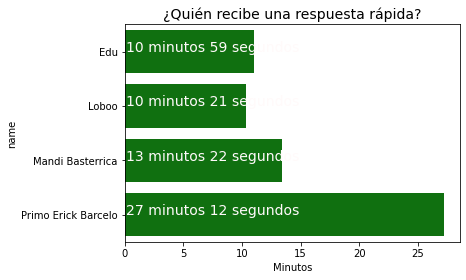

In [71]:
chat_reply(chat)

### Pegatinas de spammers

In [59]:
def spam_sticker(df):
    sticker_text = ["<Media omitted>", "\[Sticker\]"]
    df[df["message"].str.contains('|'.join(sticker_text ))]
    stiker = df[df["message"].str.contains('|'.join(sticker_text ))].groupby("name").count()

    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(stiker.message, labels=stiker.index, colors=['teal','turquoise'])
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    p.set_size_inches(5,5)
    plt.savefig("spam_sticker.jpg")
    plt.show()

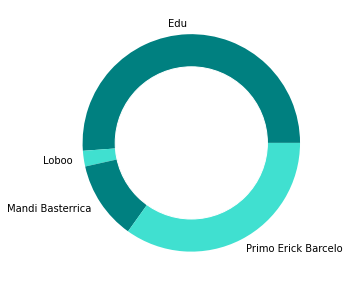

In [60]:
spam_sticker(chat)

### Weekly activity

In [51]:
def weekly_activity(df):
    df.set_index(df["time"], inplace=True)

    users = {user: df[df.name == user] for user in df.name.unique()}

    for user in users:
        users[user] = users[user]['message'].resample('W').count()

    fig,ax=plt.subplots()
    for name in users:
        ax.plot(users[name], linewidth=3)


    plt.title("Weekly Number of Messages", fontsize=30)

    fig.set_size_inches(20,7)
    plt.legend(users.keys(), loc='upper left', prop={'size': 15})
    ax.grid(True, axis='y')
    ax.set_ylabel('Numero de mensajes', fontsize=15)
    ax.set_xlabel('Dates', fontsize=15)

    dates = list(pd.to_datetime(users[name].index.to_series(), 
                               format='%Y00%m').apply(lambda x: x.strftime('%b-%Y')))
    dates = list(set([date.replace('-', ' \n') for date in dates]))
    ax.set_xticks(dates)
    ax.set_xticklabels(dates, fontsize=12)
    plt.savefig("weekly_activity.jpg")
    plt.show()

ConversionError: Failed to convert value(s) to axis units: ['Oct \n2020', 'Nov \n2020']

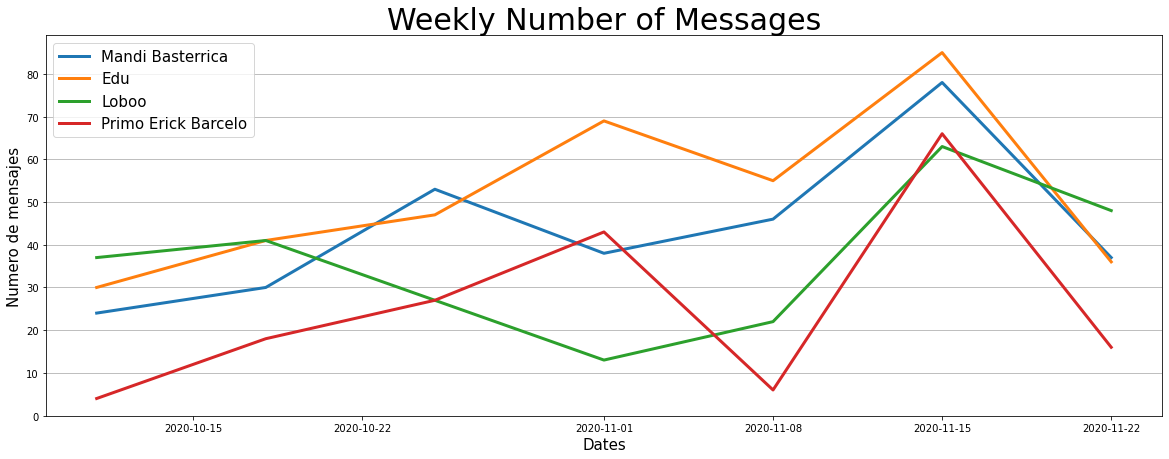

In [52]:
weekly_activity(chat)

### Daily Activity

In [72]:
def daily_activity_bar(df):
    df["DayofWeek"]=df.index.dayofweek
    df["DayofWeek"].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}, inplace=True)

    daily = df.groupby(['DayofWeek']).count()
    daily = daily.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

    fig=plt.gcf()
    ax=plt.subplot()
    sns.barplot(y=daily['message'], x=daily.index, color="blue")
    fig.set_size_inches(13,4)
    ax.set_ylabel('Number of Messages', fontsize=10)
    plt.title("Actividad Diaria",fontsize=14)
    plt.savefig('daily_activity_bar.jpg')
    plt.show()

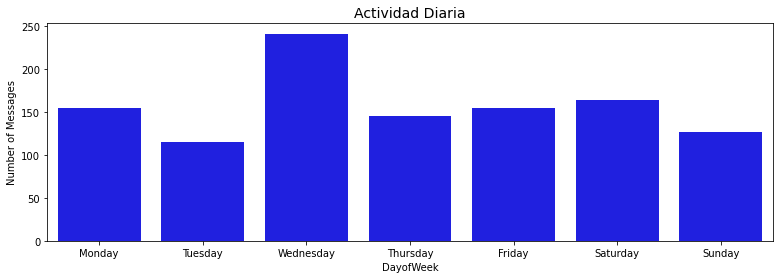

In [73]:
daily_activity_bar(chat)

In [36]:
def daily_activity_polar(df):
    df["DayofWeek"]=df.index.dayofweek
    df["DayofWeek"].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'}, inplace=True)

    daily = df.groupby(['DayofWeek']).count()
    daily = daily.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

    angles=np.linspace(0, 2*np.pi, len(daily.index), endpoint=False)
    # close the plot
    stats=(np.concatenate((daily['message'],[daily['message'][0]])))
    angles=np.flip(np.concatenate((angles,[angles[0]])))


    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, color="teal")
    ax.fill(angles, stats, alpha=0.25, color="turquoise")
    ax.set_thetagrids(angles * 180/np.pi, daily.index, fontsize=11, weight="bold")
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    fig.set_size_inches(6,6)
    ax.grid(True)
    plt.savefig('daily_activity_polar.jpg')
    plt.show()

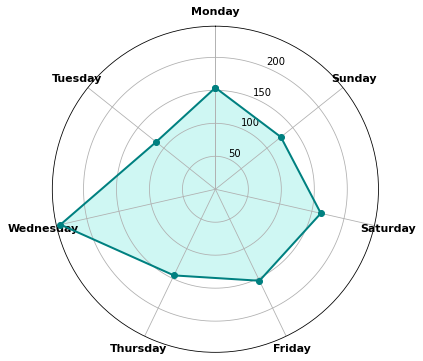

In [37]:
daily_activity_polar(chat)

### Hourly Activity

In [74]:
def hourly_activity_map(df):
    df['Hour']=pd.to_datetime(df.index.to_series()).apply(lambda x: x.strftime('%H'))
    hourly = df.groupby("Hour").count()

    fig=plt.gcf()
    ax=plt.subplot()

    plt.fill_between( x=hourly.index, y1=hourly.message, color="red", alpha=0.4)
    plt.plot(hourly.message, color="turquoise", alpha=0.6)

    fig.set_size_inches(13,4)
    ax.set_ylabel('Number of Messages', fontsize=10)
    plt.title("Hora con mas actividad",fontsize=14)
    plt.savefig('hourly_activity_map.jpg')
    plt.show()

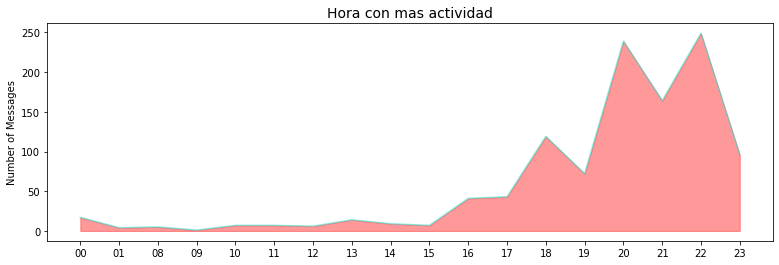

In [75]:
hourly_activity_map(chat)

In [79]:
### Hourly Activity